In [1]:
import tensorflow as tf

2025-08-12 08:58:13.298619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754989093.541222      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754989093.611481      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
# from keras_flops import get_flops


# IMG_SIZE = (224, 224)  # Adjust as needed
# BATCH_SIZE = 32
# DROPOUT_RATE = 0.3
# INITIAL_LR = 0.001
# EPOCHS = 50
# SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-split/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-split/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-split/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes

Found 23479 images belonging to 43 classes.
Found 7172 images belonging to 43 classes.
Found 7177 images belonging to 43 classes.


In [ ]:
base_model = DenseNet121(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

# Keep base model trainable (as per assignment requirement)
base_model.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

In [ ]:
checkpoint_cb = ModelCheckpoint(
    "best_densenet_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb]

print("Starting training ")
!curl -d "Train Start" ntfy.sh/model_complete

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")
!curl -d "Train Complete" ntfy.sh/model_complete

In [ ]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()


In [ ]:
model.save('densenet_final_model.keras')
model.save_weights('densenet_final.weights.h5')

In [ ]:
import pandas as pd
results = {
    "Model": ["DenseNet121"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "Finished" ntfy.sh/model_complete

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INITIAL_EPOCH = 39  # Starting from epoch 39
FINAL_EPOCH = 60    # Target epoch
ADDITIONAL_EPOCHS = FINAL_EPOCH - INITIAL_EPOCH  # 21 more epochs
SEED = 42

In [8]:
model = tf.keras.models.load_model('/kaggle/input/corn_grass_augment_60_20_20_split/keras/default/1/densenet_final_model.keras')
print(f"Model loaded successfully!")
print(f"Total parameters: {model.count_params():,}")

Model loaded successfully!
Total parameters: 8,788,843


In [9]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.0005,  # Slightly lower LR for continued training
    weight_decay=0.01
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks for continued training
callbacks = []

# 1. Save best model during continued training
checkpoint_best = ModelCheckpoint(
    "best_model_epochs39to60.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
callbacks.append(checkpoint_best)


checkpoint_final = ModelCheckpoint(
    "final_model_epoch60.h5",
    save_best_only=False,
    verbose=1
)
callbacks.append(checkpoint_final)

In [13]:
# 4. Custom callback to track epoch numbers correctly
class EpochTracker(tf.keras.callbacks.Callback):
    def __init__(self, starting_epoch):
        super().__init__()
        self.starting_epoch = starting_epoch
    
    def on_epoch_begin(self, epoch, logs=None):
        actual_epoch = self.starting_epoch + epoch + 1
        print(f"Starting epoch {actual_epoch}/60")
    
    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = self.starting_epoch + epoch + 1
        val_acc = logs.get('val_accuracy', 0)
        val_loss = logs.get('val_loss', 0)
        print(f"Completed epoch {actual_epoch}/60 - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

epoch_tracker = EpochTracker(INITIAL_EPOCH)
callbacks.append(epoch_tracker)

print("\n" + "="*60)
print("CONTINUING TRAINING")
print("="*60)
print(f"Starting from: Epoch {INITIAL_EPOCH}")
print(f"Target: Epoch {FINAL_EPOCH}")
print(f"Additional epochs: {ADDITIONAL_EPOCHS}")
print("="*60)

# Continue training
history_continued = model.fit(
    train_flow,
    epochs=ADDITIONAL_EPOCHS,        # Train for 21 more epochs
    initial_epoch=0,                 # Start from 0 in this fit call
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("\n🎉 Training continuation completed!")
print(f"Model has now been trained for {FINAL_EPOCH} epochs total")

!curl -d "Train Complete" ntfy.sh/model_complete


CONTINUING TRAINING
Starting from: Epoch 39
Target: Epoch 60
Additional epochs: 21


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Starting epoch 40/60
Starting epoch 40/60
Epoch 1/21


I0000 00:00:1754989526.854281      92 service.cc:148] XLA service 0x7f12b8001930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754989526.855282      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754989536.319919      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754989626.856169      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9883 - loss: 0.0409
Epoch 1: val_accuracy improved from -inf to 0.95371, saving model to best_model_epochs39to60.h5

Epoch 1: saving model to final_model_epoch60.h5
Completed epoch 40/60 - val_loss: 0.1888 - val_accuracy: 0.9537
Completed epoch 40/60 - val_loss: 0.1888 - val_accuracy: 0.9537
734/734 ━━━━━━━━━━━━━━━━━━━━ 551s 479ms/step - accuracy: 0.9883 - loss: 0.0409 - val_accuracy: 0.9537 - val_loss: 0.1888
Starting epoch 41/60
Starting epoch 41/60
Epoch 2/21
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9922 - loss: 0.0269
Epoch 2: val_accuracy improved from 0.95371 to 0.95733, saving model to best_model_epochs39to60.h5

Epoch 2: saving model to final_model_epoch60.h5
Completed epoch 41/60 - val_loss: 0.1850 - val_accuracy: 0.9573
Completed epoch 41/60 - val_loss: 0.1850 - val_accuracy: 0.9573
734/734 ━━━━━━━━━━━━━━━━━━━━ 149s 203ms/step - accuracy: 0.9922 - loss: 0.0269 - val_accuracy: 0.9573 - val_loss: 0.1850
St

In [16]:
# Save the final model
model.save('densenet_final_60epochs.keras')
model.save_weights('densenet_weights_60epochs.weights.h5')

print("\nSaved files:")
print("- densenet_final_60epochs.keras (final model at epoch 60)")
print("- densenet_weights_60epochs.h5 (weights at epoch 60)")
print("- best_model_epochs39to60.h5 (best model from epochs 39-60)")
print("- final_model_epoch60.h5 (final checkpoint)")




Saved files:
- densenet_final_60epochs.keras (final model at epoch 60)
- densenet_weights_60epochs.h5 (weights at epoch 60)
- best_model_epochs39to60.h5 (best model from epochs 39-60)
- final_model_epoch60.h5 (final checkpoint)



EVALUATING FINAL MODEL (60 EPOCHS)
225/225 ━━━━━━━━━━━━━━━━━━━━ 89s 346ms/step
Final Test Results (Epoch 60):
Test Loss: 0.1902
Test Accuracy: 0.9582
Precision: 0.9245
Recall: 0.9382
F1 Score: 0.9296


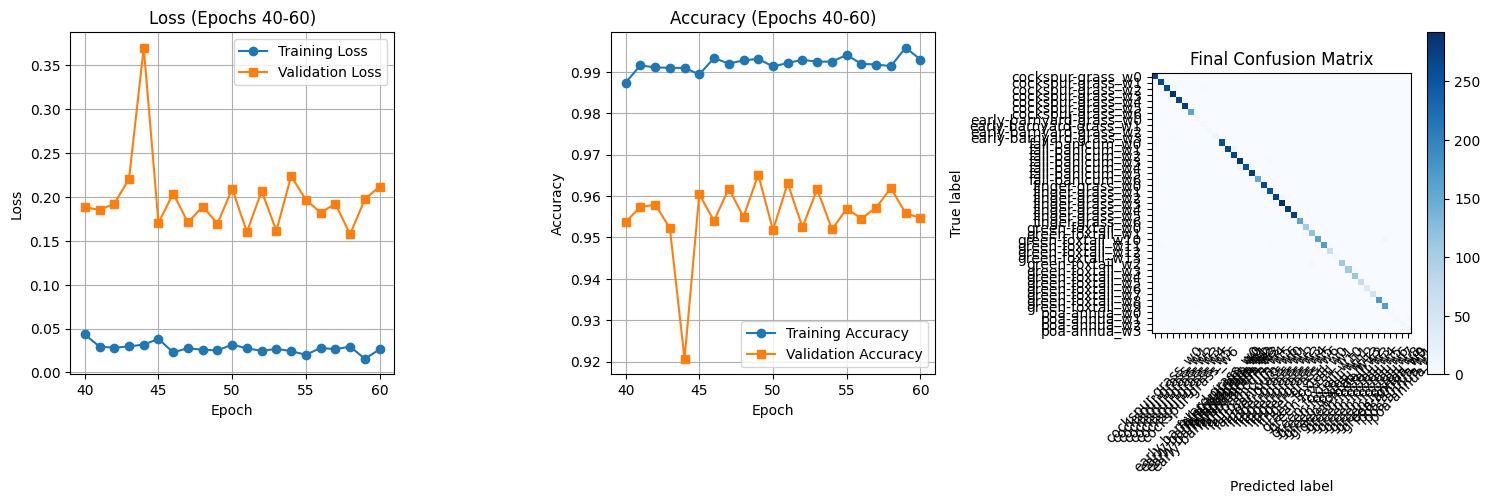


Continued Training Summary:
Best validation accuracy during continuation: 0.9651 at epoch 49
Final validation accuracy: 0.9547 at epoch 60

| Phase               |   Epochs | Test_Accuracy   | Test_Loss       | Precision       | Recall          | F1_Score        |
|:--------------------|---------:|:----------------|:----------------|:----------------|:----------------|:----------------|
| Original (Epoch 39) |       39 | Previous result | Previous result | Previous result | Previous result | Previous result |
| Final (Epoch 60)    |       60 | 0.9582          | 0.1902          | 0.9245          | 0.9382          | 0.9296          |

✅ SUCCESS: Model training continued from epoch 39 to epoch 60!
The 'densenet_final_60epochs.keras' file now contains weights from epoch 60.


In [17]:
# Evaluate final model
print("\n" + "="*50)
print("EVALUATING FINAL MODEL (60 EPOCHS)")
print("="*50)

test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

print(f"Final Test Results (Epoch 60):")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot training curves for the continued training
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
epochs_range = range(INITIAL_EPOCH + 1, FINAL_EPOCH + 1)
plt.plot(epochs_range, history_continued.history["loss"], label="Training Loss", marker='o')
plt.plot(epochs_range, history_continued.history["val_loss"], label="Validation Loss", marker='s')
plt.title(f"Loss (Epochs {INITIAL_EPOCH+1}-{FINAL_EPOCH})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history_continued.history["accuracy"], label="Training Accuracy", marker='o')
plt.plot(epochs_range, history_continued.history["val_accuracy"], label="Validation Accuracy", marker='s')
plt.title(f"Accuracy (Epochs {INITIAL_EPOCH+1}-{FINAL_EPOCH})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Final Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.show()

# Summary of continued training
val_accuracies = history_continued.history['val_accuracy']
best_continued_epoch = INITIAL_EPOCH + 1 + np.argmax(val_accuracies)
best_continued_acc = max(val_accuracies)

print(f"\nContinued Training Summary:")
print(f"Best validation accuracy during continuation: {best_continued_acc:.4f} at epoch {best_continued_epoch}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f} at epoch {FINAL_EPOCH}")

# Create comprehensive results
import pandas as pd
results = {
    "Phase": ["Original (Epoch 39)", "Final (Epoch 60)"],
    "Epochs": [39, 60],
    "Test_Accuracy": ["Previous result", f"{test_acc:.4f}"],
    "Test_Loss": ["Previous result", f"{test_loss:.4f}"],
    "Precision": ["Previous result", f"{precision:.4f}"],
    "Recall": ["Previous result", f"{recall:.4f}"],
    "F1_Score": ["Previous result", f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print("\n" + df.to_markdown(index=False))

print(f"\n✅ SUCCESS: Model training continued from epoch 39 to epoch 60!")
print(f"The 'densenet_final_60epochs.keras' file now contains weights from epoch 60.")